<a href="https://colab.research.google.com/github/Shubh-1879/Random-Projects/blob/main/CNN_Mammals_Shubham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries


In [ ]:
! [ -e /content ] && pip install -Uqq fastai

The above cell is to upgrade fastai on colab (from here: https://github.com/fastai/fastai/blob/master/nbs/10_tutorial.pets.ipynb)

!: To indicate that the following command should be executed in the the command line rather than as Python code.

[ -e /content ]: Checks if a file or directory exists.

-U: Flag - for "upgrade". Tells pip to upgrade the package to the latest version if it's already installed.

-qq: "quiet" mode. The -q option reduces the output of the command. Using -qq makes it even quieter, suppressing all output except for errors.


In [ ]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url

Importing all necessary tools, modules, functions from fastai and fastdownload library

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pip install -q bing-image-downloader


Installing Bing's image downloader

In [ ]:
import os
import contextlib
from bing_image_downloader import downloader
from pathlib import Path
path = Path().cwd()/"Mammals" #appends the "Mammals" directory to the current working directory path

numberOfImagesForEachClass = 80 # downloading 80 images for each mammal type

mammal_types=['Black cats', 'Brown dogs', 'Asian elephants', 'Dolphins']

with contextlib.redirect_stdout(open(os.devnull, 'w')): #to curb output lines; to redirect the output to suppress print statements from the bing_image_downloader library
  for o in mammal_types:
    downloader.download(o,  limit=numberOfImagesForEachClass,  output_dir=path, adult_filter_off=True, force_replace=False)


How suppressing the output works:

*with contextlib.redirect_stdout(open(os.devnull, 'w')):*

This line starts a context manager to suppress any output (such as print statements) that would normally be printed to the console.

*open(os.devnull, 'w'):* opens a special file-like object called os.devnull. Anything written to os.devnull is discarded, effectively silencing any output.

*contextlib.redirect_stdout():* temporarily redirects all output (stdout) to os.devnull, silencing it.

Our folder 'Mammals' now has the downloaded images. Running the code below to see their saved path in the drive.

In [ ]:
fns = get_image_files(path)
fns

(#994) [Path('/content/Mammals/Brown cats/Image_58.jpg'),Path('/content/Mammals/Brown cats/Image_76.jpg'),Path('/content/Mammals/Brown cats/Image_54.jpg'),Path('/content/Mammals/Brown cats/Image_80.jpg'),Path('/content/Mammals/Brown cats/Image_23.jpeg'),Path('/content/Mammals/Brown cats/Image_1.jpg'),Path('/content/Mammals/Brown cats/Image_65.jpg'),Path('/content/Mammals/Brown cats/Image_59.jpg'),Path('/content/Mammals/Brown cats/Image_24.jpg'),Path('/content/Mammals/Brown cats/Image_11.jpg')...]

In [ ]:
mammals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #Had a doubt here
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #20% of the images will be used as the validation set, and 80% will be used for training
    get_y=parent_label,
    item_tfms=Resize(128))
dls = mammals.dataloaders(path)

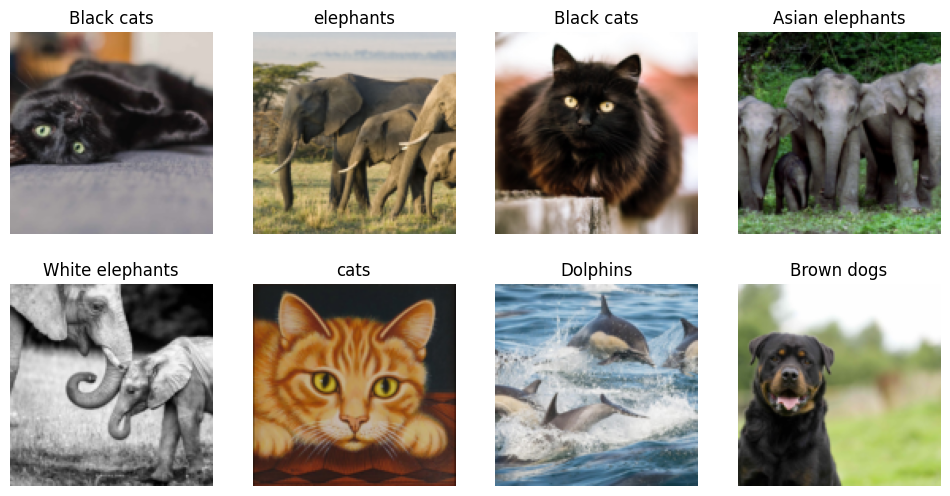

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

### Data Augmentation

Epoch => one complete pass through all of our images in the dataset

On each epoch, randomly select a part of the image, and crop to that part. This is done to imitate and account for real world circumstances where image of the same object may be slightly different, e.g. same image rotated by a few degrees. Parts of image that are repeated over several epochs are better "recognised".

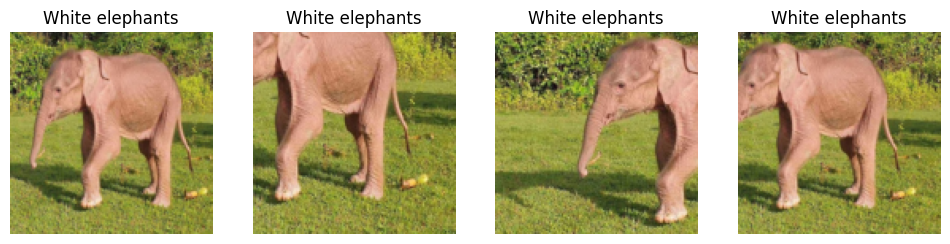

In [ ]:
mammals = mammals.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
# first crops a random portion of the image, then resizes that portion to the specified size (128x128);
# the minimum size of the crop. In this case, the cropped portion will be
# at least 30% of the original image size
dls = mammals.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

unique=True is used to have the same image repeated with different versions of this RandomResizedCrop transform

## Training the Model


In [ ]:
mammals = mammals.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = mammals.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
epochs = 3 #The more the number of epochs, the more accurate are the results from the model
learn.fine_tune(epochs)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,3.074673,1.223901,0.474747,03:14


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.418699,0.906997,0.343434,04:26
1,1.185603,0.839082,0.303030,04:25
2,1.022833,0.810965,0.272727,04:27


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


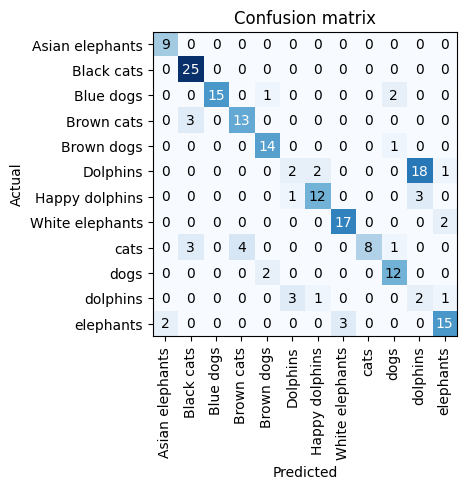

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix() # Doubt

### Save the model
Using fastai's export function, the file is saved as"export.pkl":

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

In [ ]:
# Create an output widget to display the uploaded image
out_pl = widgets.Output()
out_pl.clear_output()

# Label widget to display the model's prediction
lbl_pred = widgets.Label()

# Button to trigger image classification
btn_run = widgets.Button(description='Classify')

# File upload widget to allow users to upload an image
btn_upload = widgets.FileUpload()


def on_click_classify(change):
    # To read the uploaded image
    img = PILImage.create(btn_upload.data[-1])

    # Clear previous output and display the new image
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(256, 256))

    # Perform prediction using the trained model
    pred, pred_idx, probs = learn_inf.predict(img)

    # Update label with prediction results
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

# Attach the function to the button's click event
btn_run.on_click(on_click_classify)

### Checking our Model's prediction

- Download an image of any of the classes of mammals

- upload it by running the code snippet below

- click on 'Classify'

In [ ]:
#hide_output
VBox([widgets.Label('Select an image!'),
      btn_upload, btn_run, out_pl, lbl_pred])

## References

The above tutorial is taken from fast.ai's course Practical Deep Learning for coders.
- reattempted from Satripta Makhija's tutorial by Shubham Agarwal